**Reference:** 
* [UNet model Original creator Reference link](https://github.com/zhixuhao/unet)
* [Kaggle Notebook - SAMUEL CORTINHAS](https://www.kaggle.com/code/samuelcortinhas/case-study-u-net-from-scratch#Application:-Tumor-detection)
* [UNet from Scratch - segmentation 🧠 Tumour](https://www.kaggle.com/code/tejasurya/unet-from-scratch-segmentation-tumour) - Main SOurce

In [51]:
!pip install -qqq segmentation-models-pytorch
!pip install -qqq torchmetrics

In [52]:
# importing required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import gc
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp


%matplotlib inline
from IPython.display import Image, display
from skimage import io

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import normalize

from PIL import Image

import torchvision
from torchvision import transforms

In [53]:
data_path = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [54]:
filenames = data_path[::2]
masks = data_path[1::2]

In [55]:
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})
print("initial data size frame", df.shape) 
df=df[:200]
df

initial data size frame (7858, 2)


,patient_id,img_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
195,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
196,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
197,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
198,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [56]:
org_image = df[~df['img_path'].str.contains("mask")]
mask_image = df[df['img_path'].str.contains("mask")]

In [57]:
org_image, mask_image

(                patient_id                                           img_path
 0    TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 2    TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 3    TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 4    TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 5    TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 ..                     ...                                                ...
 190  TCGA_FG_A4MT_20020212  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 191  TCGA_FG_A4MT_20020212  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 193  TCGA_FG_A4MT_20020212  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 196  TCGA_FG_A4MT_20020212  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 197  TCGA_FG_A4MT_20020212  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 
 [100 rows x 2 columns],
                 patient_

In [58]:
img_s = sorted(org_image["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_image["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting check
idx = random.randint(0, len(img_s)-1)
print("Image path:", img_s[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_50.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_50_mask.tif


In [59]:
print(len(img_s))
print(len(masks))

100
100


In [60]:
brain_mri_df = pd.DataFrame({"patient_id": org_image.patient_id.values,"img_path": img_s,
                           'mask_path':masks})
brain_mri_df

,patient_id,img_path,mask_path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...,...
95,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
96,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
97,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
98,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [61]:
def tumor_check(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [62]:
brain_mri_df['mask'] = brain_mri_df['mask_path'].apply(lambda x: tumor_check(x))

brain_mri_df['mask_path'] = brain_mri_df['mask_path'].apply(lambda x: str(x))

print(brain_mri_df.shape)
brain_mri_df

(100, 4)


,patient_id,img_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
95,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
96,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
97,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
98,TCGA_FG_A4MT_20020212,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [63]:
brain_mri_df.drop(columns=['patient_id'],inplace=True)

In [64]:
# preparing loaders
img_trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),

])

msk_trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

In [65]:
# Normalizing pixels

def pix_brightness(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    
    return (img, mask)

In [66]:
#initializing Dataset

class prepareDs(Dataset):
    def __init__(self, df= brain_mri_df, 
                 pix_brightness = pix_brightness, 
                 img_trans=img_trans, msk_trans=msk_trans):
        self.df = df
        self.img_trans = img_trans
        self.msk_trans = msk_trans
        self.pix_brightness= pix_brightness

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        image, mask = self.pix_brightness(image, mask)

        if self.img_trans:
            image = self.img_trans(image).float()

        if self.msk_trans:
            mask = self.msk_trans(mask)
        return image, mask

In [67]:
def Data_loaders(df= brain_mri_df,
                    train_num= int(brain_mri_df.shape[0] * .6), 
                    valid_num= int(brain_mri_df.shape[0] * .8), 
                    bs = 32):
    
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num : valid_num].reset_index(drop=True)    
    test  = df[valid_num:].reset_index(drop=True)

    train_ds = prepareDs(df = train)
    valid_ds = prepareDs(df = valid)
    test_ds = prepareDs(df = test)

    train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 4, shuffle = True)
    
    print("completed setting up")
    
    return train_loader, valid_loader, test_loader,len(train_ds),len(test_ds)

In [68]:
train_loader, valid_loader, test_loader,train_len,test_len = Data_loaders(df= brain_mri_df,
                                                            train_num= int(brain_mri_df.shape[0] * .65), 
                                                            valid_num= int(brain_mri_df.shape[0] * .85), 
                                                            bs = 32)

completed setting up


In [69]:
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

In [70]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [71]:
class Block(nn.Module):
    def __init__(self, inputs = 3, middles = 64, outs = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outs)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):        
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))        
        return self.pool(x), x   

In [72]:

class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        #Encoders
        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)

        #Decoders
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)       
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)

    def forward(self, x):
        x, e1 = self.en1(x)     
        x, e2 = self.en2(x)
        x, e3 = self.en3(x) 
        x, e4 = self.en4(x)
        _, x = self.en5(x)

        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        _,  x = self.de4(x)
        
        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        _, x = self.de3(x)
        
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        _, x = self.de2(x)
        
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        _, x = self.de1(x)
        
        x = self.conv_last(x)              
        return x
        


        

In [73]:
unet = UNet().to(device)
unet

UNet(
  (en1): Block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en2): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en3): Block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(256, eps=1e-05, momentum

## <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Loss_fn & Optimizer</span> <a id=5></a>

In [74]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss,MSELoss,BCELoss,CrossEntropyLoss
# loss_fn = BCEWithLogitsLoss()
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(unet.parameters(), )

In [75]:
# training one epoch
def train_one_epoch(model = unet, 
                    dataloader = train_loader, 
                    loss_fn = loss_fn, 
                    optimizer = optimizer, 
                    epoch = 1):
    model.train() 
    train_loss, dataset_size = 0,  0
    
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    for data in bar:
        x = data[0].cuda()  
        y_true = data[1].cuda()
        y_pred = model(x)          
        
        loss = loss_fn(y_pred, y_true)
        
        pred_mask = (y_pred > 0.5).float()
        btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        bs = x.shape[0]
        dataset_size += bs
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size
        
        tp_l.append(btp)
        fp_l.append(bfp)
        fn_l.append(bfn)
        tn_l.append(btn)
        
        tp = torch.cat(tp_l)
        fp = torch.cat(fp_l)
        fn = torch.cat(fn_l)
        tn = torch.cat(tn_l)
        
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        
        


        bar.set_description(f"EP:{epoch} | TL:{train_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")
        
    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    
    metrics['loss'] = train_epoch_loss

    return metrics

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">valid_one_epoch</span> <a id=5.1></a> <br>

In [76]:
@torch.no_grad()
def valid_one_epoch(model = unet, 
                    dataloader = valid_loader, 
                    loss_fn = loss_fn,
                    epoch = 0):
    model.eval() 
    valid_loss, dataset_size = 0,  0
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    with torch.no_grad():
        for data in bar:
            x = data[0].cuda()    
            y_true = data[1].cuda() 
            y_pred = model(x)        
            
            loss = loss_fn(y_pred, y_true)
            
            pred_mask = (y_pred > 0.5).float()
            btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

            tp_l.append(btp)
            fp_l.append(bfp)
            fn_l.append(bfn)
            tn_l.append(btn)

            tp = torch.cat(tp_l)
            fp = torch.cat(fp_l)
            fn = torch.cat(fn_l)
            tn = torch.cat(tn_l)

            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

           
            bs = x.shape[0]
            dataset_size += bs
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size

            bar.set_description(f"EP:{epoch} | VL:{valid_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")

    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    
    metrics['loss'] = valid_epoch_loss

    return metrics

In [77]:
# Training set up
import copy

def run_training(model = unet, 
                 loss_fn = loss_fn, 
                 train_loader = train_loader,
                 valid_loader = valid_loader,
                 optimizer = optimizer, 
                 n_epochs=100, 
                 early_stop = 20,
                 scheduler = None):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    lowest_epoch, lowest_loss = np.inf, np.inf
    
    train_history, valid_history = [],  []
    train_recalls, valid_recalls = [],  []
    
    train_pres, valid_pres = [],  []
    train_accs, valid_accs = [],  []
    
    train_f1s, valid_f1s = [],  []
    
    train_per_ious, valid_per_ious = [], []
    train_dataset_ious, valid_dataset_ious = [], []
    
    print_iter = 5

    best_score = 0
    best_model = "None"

    for epoch in range(0, n_epochs):
        gc.collect()

        train_metrics = train_one_epoch(model= model,
                                       dataloader = train_loader,
                                       optimizer = optimizer,
                                       epoch = epoch + 1
                                       )
        
        valid_metrics = valid_one_epoch(model,
                                       dataloader = valid_loader,
                                       epoch = epoch + 1)
        
        
        train_history += [train_metrics['loss']]
        valid_history += [valid_metrics['loss']]
        
        train_recalls += [train_metrics['recall']]
        valid_recalls += [valid_metrics['recall']]
        
        train_pres += [train_metrics['precision']]
        valid_pres += [valid_metrics['precision']]
        
        train_accs += [train_metrics['accuracy']]
        valid_accs += [valid_metrics['accuracy']]
        
        train_f1s += [train_metrics['f1_score']]
        valid_f1s += [valid_metrics['f1_score']]

        
        print()
        if (epoch + 1) % print_iter == 0:
            print(f"Epoch:{epoch + 1}|TL:{train_metrics['loss']:.3e}|VL:{valid_metrics['loss']:.3e}|F1:{valid_metrics['f1_score']:.4f}")
            print()
            
        if best_score < valid_metrics['f1_score']:
            print("!111")
            print(f"Validation F1 Improved({best_score:.2f}) --> ({ valid_metrics['f1_score']:.2f})")
            best_model = model
            best_score = valid_metrics['f1_score']
            best_model = copy.deepcopy(model.state_dict())
            PATH2 =  f"model_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_Model Saved")
            print()

        if valid_metrics['loss']< lowest_loss:
            print("!222")
            print(f"Validation Loss Improved({lowest_loss:.4e}) --> ({ valid_metrics['loss']:.4e})")
            lowest_loss = valid_metrics['loss']
            lowest_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"model.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved")
            print()
       
                
    print()
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: %.4e at %d th Epoch" % (lowest_loss, lowest_epoch))

    
    model.load_state_dict(torch.load('./model_f1.bin'))

    result = dict()
    result["Train Loss"] = train_history
    result["Valid Loss"] = valid_history
    
    result["Train Recall"] = train_recalls
    result["Valid Recall"] = valid_recalls
    
    result["Train Precision"] = train_pres
    result["Valid Precision"] = valid_pres
    
    result["Train Accuracy"] = train_accs
    result["Valid Accuracy"] = valid_accs
    
    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
    
    
    return model, result

In [78]:
# Training the model
model, result = run_training(model = unet, 
                             loss_fn = loss_fn, 
                             optimizer = optimizer, 
                             n_epochs = 10)

INFO: GPU - Tesla T4



EP:1 | TL:9.689e-01 | ACC: 0.80 | F1: 0.025 : 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]
EP:1 | VL:9.474e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]



!222
Validation Loss Improved(inf) --> (9.4742e-01)
Better Loss Model Saved



EP:2 | TL:9.753e-01 | ACC: 0.63 | F1: 0.032 : 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
EP:2 | VL:9.470e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



!222
Validation Loss Improved(9.4742e-01) --> (9.4697e-01)
Better Loss Model Saved



EP:3 | TL:9.721e-01 | ACC: 0.73 | F1: 0.040 : 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
EP:3 | VL:9.423e-01 | ACC: 0.74 | F1: 0.153 : 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



!111
Validation F1 Improved(0.00) --> (0.15)
Better_F1_Model Saved

!222
Validation Loss Improved(9.4697e-01) --> (9.4227e-01)
Better Loss Model Saved



EP:4 | TL:9.566e-01 | ACC: 0.69 | F1: 0.036 : 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
EP:4 | VL:9.776e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


EP:5 | TL:9.564e-01 | ACC: 0.69 | F1: 0.037 : 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]
EP:5 | VL:9.496e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch:5|TL:9.564e-01|VL:9.496e-01|F1:0.0000



EP:6 | TL:9.550e-01 | ACC: 0.72 | F1: 0.041 : 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
EP:6 | VL:9.461e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


EP:7 | TL:9.694e-01 | ACC: 0.75 | F1: 0.045 : 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
EP:7 | VL:9.447e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


EP:8 | TL:9.573e-01 | ACC: 0.81 | F1: 0.046 : 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
EP:8 | VL:9.456e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


EP:9 | TL:9.541e-01 | ACC: 0.77 | F1: 0.047 : 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]
EP:9 | VL:9.464e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


EP:10 | TL:9.528e-01 | ACC: 0.75 | F1: 0.045 : 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
EP:10 | VL:9.553e-01 | ACC: 0.97 | F1: 0.000 : 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch:10|TL:9.528e-01|VL:9.553e-01|F1:0.0000


Training complete in 0h 0m 42s
Best Loss: 9.4227e-01 at 2 th Epoch


# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Visualize</span> <a id=5.3></a>

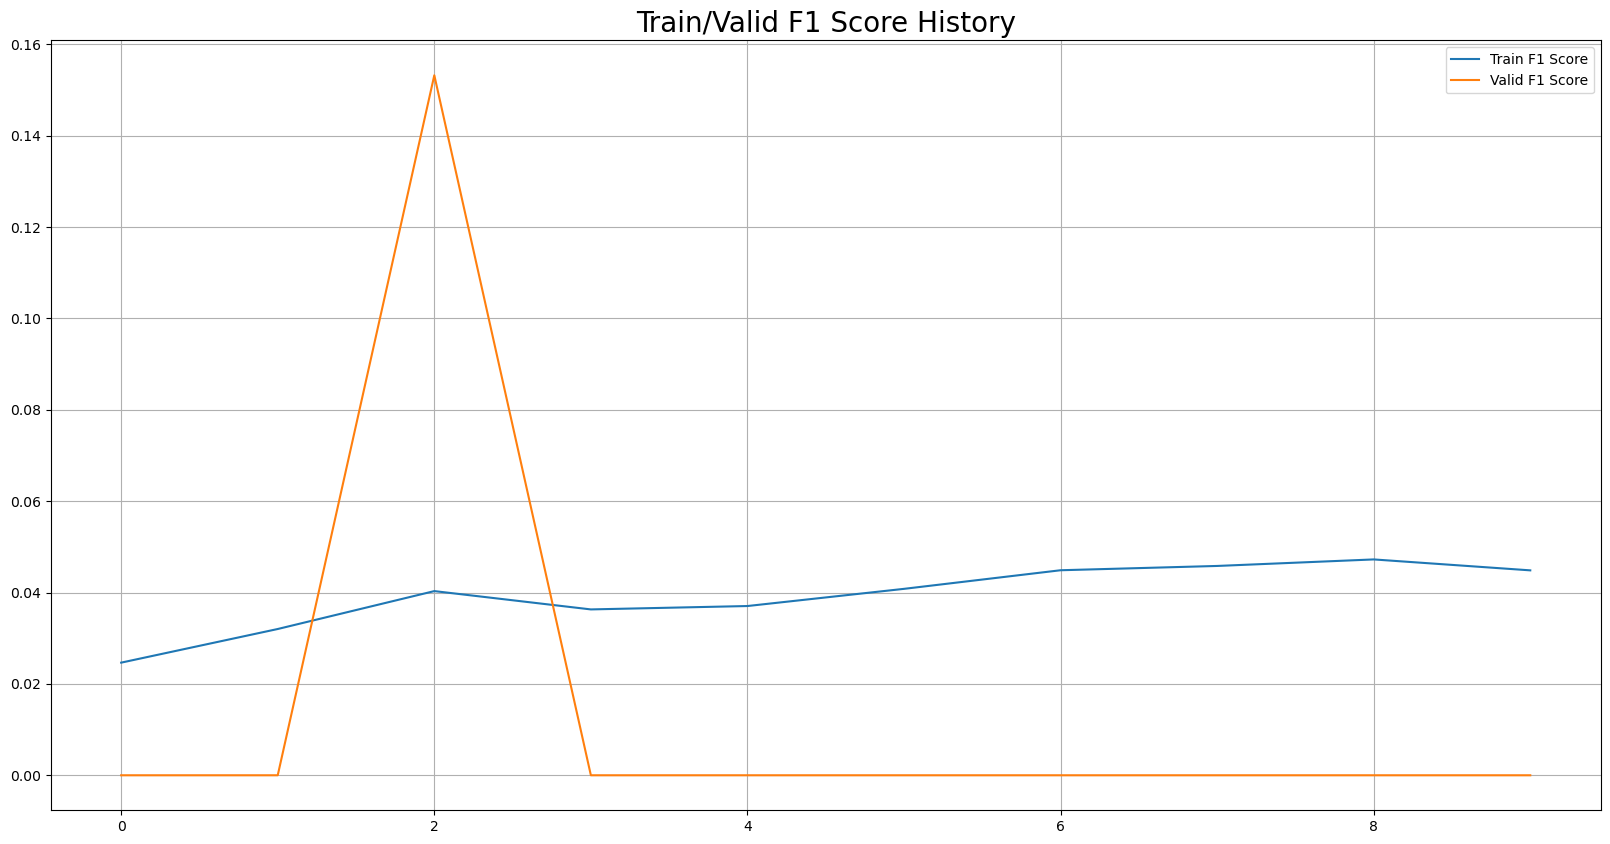

In [79]:
## Train/Valid F1 History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid F1 Score History", fontsize = 20)
plt.plot(
    range(0, len(result['Train F1 Score'][plot_from:])), 
    result['Train F1 Score'][plot_from:], 
    label = 'Train F1 Score'
    )

plt.plot(
    range(0, len(result['Valid F1 Score'][plot_from:])), 
    result['Valid F1 Score'][plot_from:], 
    label = 'Valid F1 Score'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)

# <span class="list-group-item list-group-item-action active" style="color:#FF0000;background-color:white;font-size:25px">Evaluation</span> <a id=6></a>

Evaluation metrics are listed below

# F1Model

In [80]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model_f1.bin'))

<All keys matched successfully>

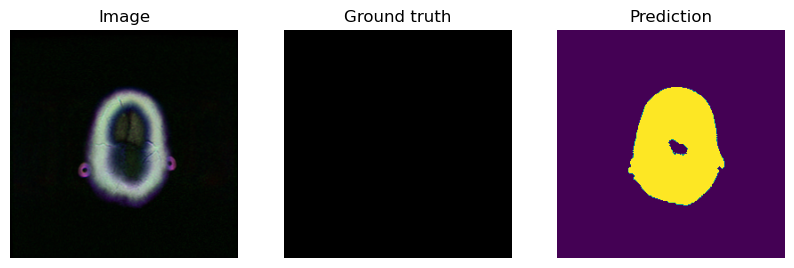

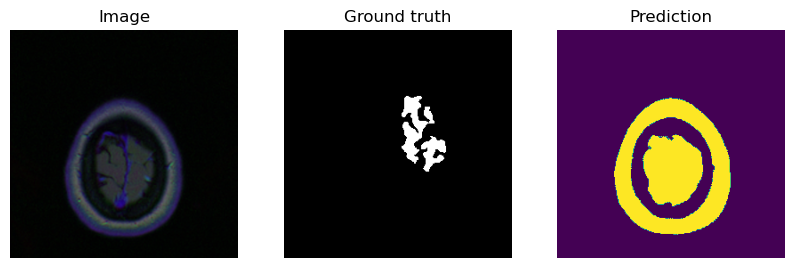

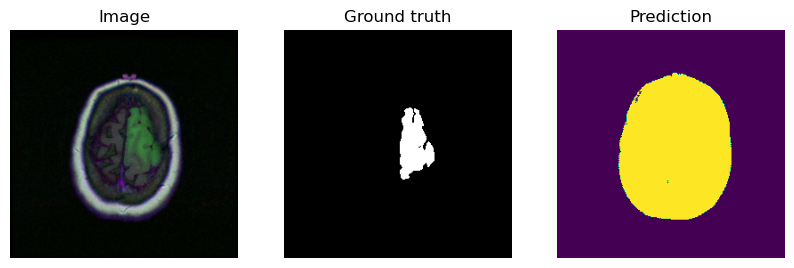

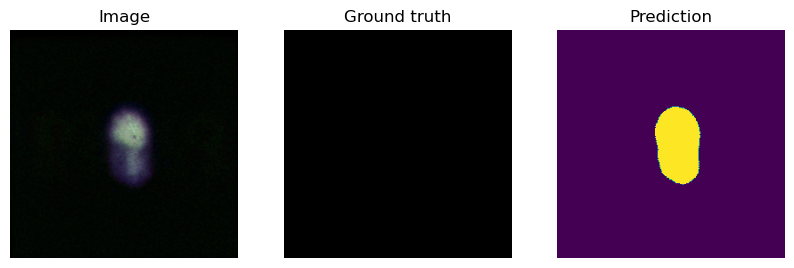

In [81]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].cuda())
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

## Better Loss Model

In [82]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model.bin'))

<All keys matched successfully>

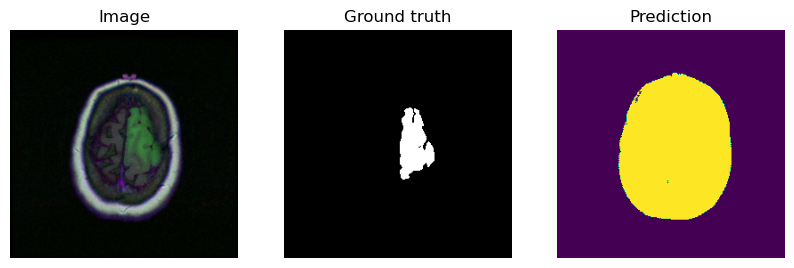

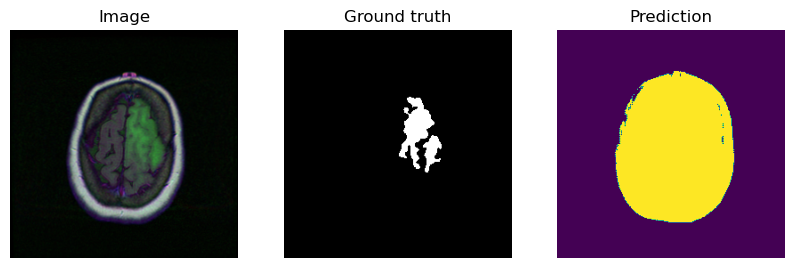

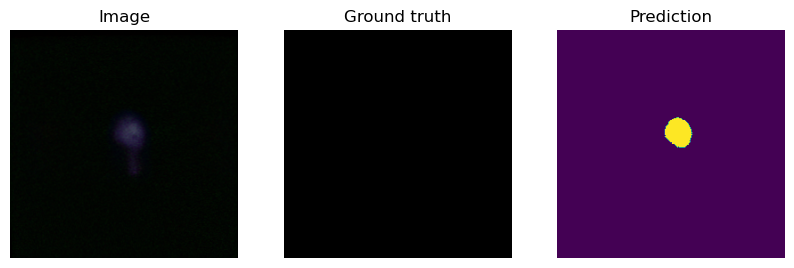

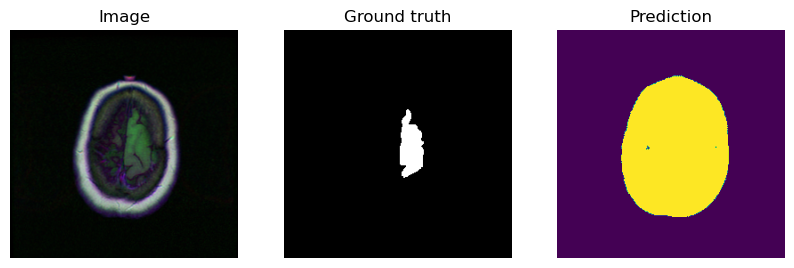

In [83]:
# i am not sure for this cell works well

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()